Notebook für das Praktikum 3 - Compton Strahlung

Energieeichung für das Messen der Daten

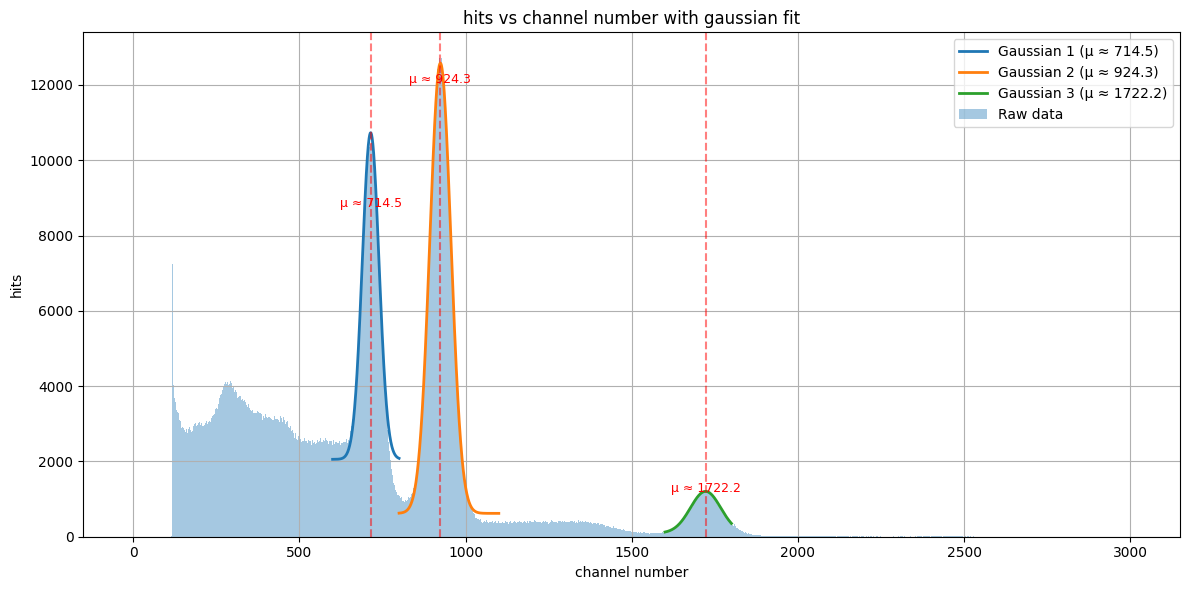


📍 Gaussian Peak Centers (μ):
  Peak 1: μ = 714.46 (ADC Channel)
  Peak 2: μ = 924.26 (ADC Channel)
  Peak 3: μ = 1722.15 (ADC Channel)


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load and clean
df = pd.read_csv("Energieeichung.csv", header=None, dtype=str)
df[0] = df[0].str.replace(";", "", regex=False)
df[0] = pd.to_numeric(df[0], errors='coerce')
df_clean = df[0].dropna().reset_index(drop=True).iloc[:3000]

x = df_clean.index.values
y = df_clean.values

# Gaussian function
def gaussian(x, A, mu, sigma, offset):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) + offset

# Define manual fit windows around peaks
peak_ranges = [
    (600, 800),
    (800, 1100),
    (1600, 1800)
]

plt.figure(figsize=(12, 6))
plt.bar(x, y, width=1.0, label="Raw data", alpha=0.4)

# Store peak centers
peak_centers = []

for i, (start, end) in enumerate(peak_ranges):
    x_peak = x[start:end]
    y_peak = y[start:end]

    # Initial guess
    A0 = y_peak.max()
    mu0 = x_peak[np.argmax(y_peak)]
    sigma0 = 10
    offset0 = y_peak.min()
    p0 = [A0, mu0, sigma0, offset0]

    try:
        popt, _ = curve_fit(gaussian, x_peak, y_peak, p0=p0)
        A, mu, sigma, offset = popt
        x_fit = np.linspace(start, end, 500)
        y_fit = gaussian(x_fit, *popt)

        # Plot the fit
        plt.plot(x_fit, y_fit, label=f"Gaussian {i+1} (μ ≈ {mu:.1f})", linewidth=2)

        # Mark the peak center
        plt.axvline(mu, color='red', linestyle='--', alpha=0.5)
        plt.text(mu, A, f"μ ≈ {mu:.1f}", ha="center", va="bottom", fontsize=9, color="red")

        # Save peak center
        peak_centers.append(mu)

    except RuntimeError:
        print(f"⚠️ Gaussian fit {i+1} failed.")

plt.xlabel("channel number")
plt.ylabel("hits")
plt.title("hits vs channel number with gaussian fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print peak centers for later calibration
print("\n📍 Gaussian Peak Centers (μ):")
for i, mu in enumerate(peak_centers, 1):
    print(f"  Peak {i}: μ = {mu:.2f} (ADC Channel)")


Now we want to fit these points to find the energy E = ax+b

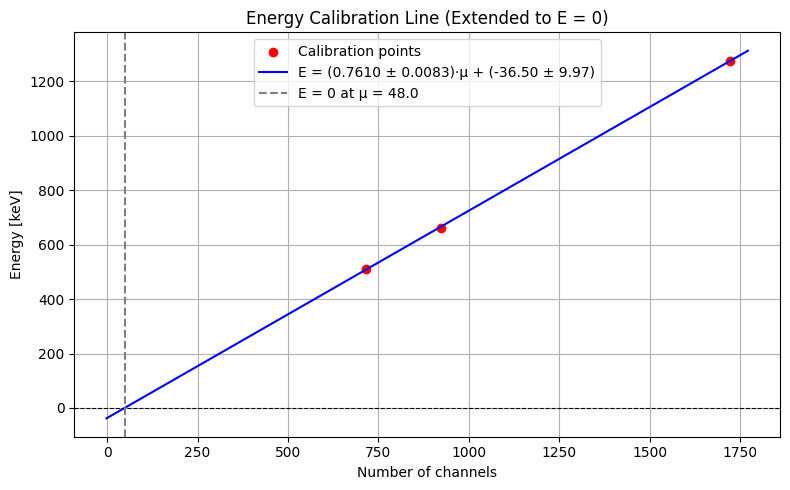

✅ Energy calibration fit:
    E = (0.7610 ± 0.0083) × μ + (-36.50 ± 9.97) [keV]
    → E = 0 occurs at μ = 47.97


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- Insert your measured μ-values and known energies ---
mu_values = np.array([714.46, 924.26, 1722.15])  # measured ADC channel centers
energies = np.array([511, 662, 1275])         # corresponding energies in keV

# --- Linear function for calibration ---
def linear(x, a, b):
    return a * x + b

# --- Fit with curve_fit to get parameters and uncertainties ---
popt, pcov = curve_fit(linear, mu_values, energies)
a, b = popt
da, db = np.sqrt(np.diag(pcov))  # standard uncertainties

# --- Calculate where line crosses E = 0 ---
mu_at_E0 = -b / a

# --- Define plotting range to include that x-intercept ---
mu_min = min(mu_values.min(), mu_at_E0) - 50
mu_max = max(mu_values.max(), mu_at_E0) + 50
mu_fit = np.linspace(mu_min, mu_max, 500)
E_fit = linear(mu_fit, a, b)

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.scatter(mu_values, energies, color='red', label="Calibration points")
plt.plot(mu_fit, E_fit, label=f"E = ({a:.4f} ± {da:.4f})·μ + ({b:.2f} ± {db:.2f})", color='blue')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(mu_at_E0, color='gray', linestyle='--', label=f"E = 0 at μ = {mu_at_E0:.1f}")

# --- Labels and layout ---
plt.xlabel("Number of channels")
plt.ylabel("Energy [keV]")
plt.title("Energy Calibration Line (Extended to E = 0)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Output result ---
print("✅ Energy calibration fit:")
print(f"    E = ({a:.4f} ± {da:.4f}) × μ + ({b:.2f} ± {db:.2f}) [keV]")
print(f"    → E = 0 occurs at μ = {mu_at_E0:.2f}")


Determination of zero scattering angle - with a Gaussian fit

<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
C:\Users\andri\AppData\Local\Temp\ipykernel_6996\4126377975.py:29: SyntaxWarning: invalid escape sequence '\s'
  plt.errorbar(theta, counts, yerr=errors, fmt='*', capsize=10, label='$\sqrt{n}$ data with errorbars')


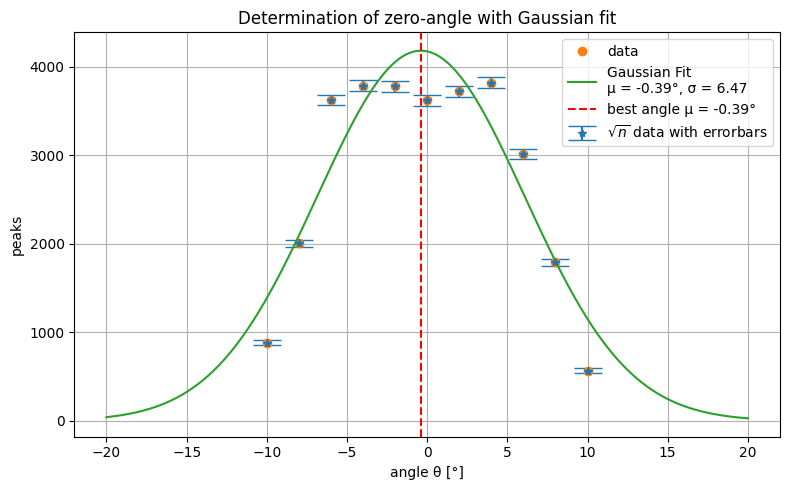

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Gegebene Daten
theta = np.array([-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10])
counts = np.array([883, 2003, 3624, 3786, 3776, 3619, 3720, 3820, 3014, 1789, 568])

# Definiere Gauss-Funktion
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Anfangsschätzungen für den Fit
initial_guess = [max(counts), 0, 3]

# Fit durchführen
params, covariance = curve_fit(gaussian, theta, counts, p0=initial_guess)
A_fit, mu_fit, sigma_fit = params

# Fit-Kurve generieren
x_fit = np.linspace(-20, 20, 500)
y_fit = gaussian(x_fit, A_fit, mu_fit, sigma_fit)

#Fehlerbalken berechen: sqrt(N) für Poisson-Statistik
errors = np.sqrt(counts)

# Plot erstellen
plt.figure(figsize=(8, 5))
plt.errorbar(theta, counts, yerr=errors, fmt='*', capsize=10, label='$\sqrt{n}$ data with errorbars')
plt.plot(theta, counts, 'o', label='data')
plt.plot(x_fit, y_fit, '-', label=f'Gaussian Fit\nμ = {mu_fit:.2f}°, σ = {sigma_fit:.2f}')
plt.title('Determination of zero-angle with Gaussian fit')
plt.xlabel('angle θ [°]')
plt.ylabel('peaks')
plt.grid(True)
plt.axvline(mu_fit, color='red', linestyle='--', label=f'best angle μ = {mu_fit:.2f}°')
plt.legend()
plt.tight_layout()
plt.show()


<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
C:\Users\andri\AppData\Local\Temp\ipykernel_6996\665376714.py:31: SyntaxWarning: invalid escape sequence '\s'
  plt.errorbar(theta, counts, yerr=errors, fmt='*', capsize=10, label='$\sqrt{n}$ errors')


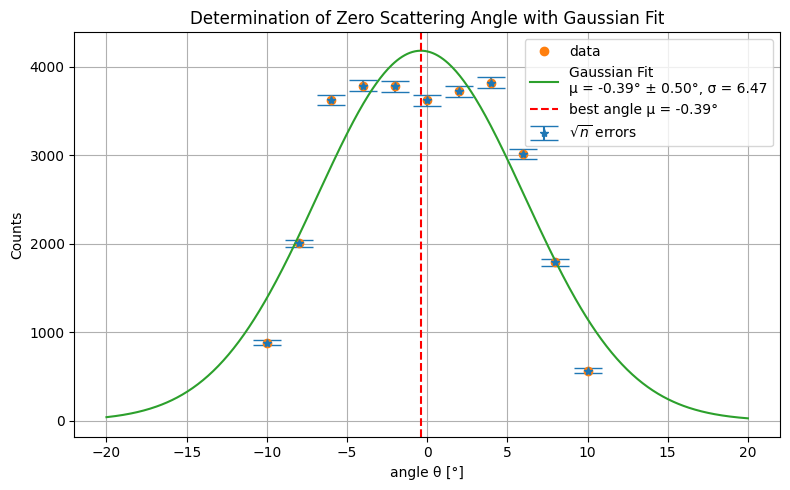

μ = -0.39° ± 0.50°


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Gegebene Daten
theta = np.array([-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10])
counts = np.array([883, 2003, 3624, 3786, 3776, 3619, 3720, 3820, 3014, 1789, 568])

# Gauss-Funktion definieren
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Anfangsschätzungen
initial_guess = [max(counts), 0, 3]

# Fit durchführen
params, covariance = curve_fit(gaussian, theta, counts, p0=initial_guess)
A_fit, mu_fit, sigma_fit = params
errors_fit = np.sqrt(np.diag(covariance))  # Standardabweichungen der Fit-Parameter
mu_error = errors_fit[1]  # Unsicherheit von μ

# Fit-Kurve
x_fit = np.linspace(-20, 20, 500)
y_fit = gaussian(x_fit, A_fit, mu_fit, sigma_fit)

# Fehlerbalken: Poisson-Statistik
errors = np.sqrt(counts)

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(theta, counts, yerr=errors, fmt='*', capsize=10, label='$\sqrt{n}$ errors')
plt.plot(theta, counts, 'o', label='data')
plt.plot(x_fit, y_fit, '-', label=f'Gaussian Fit\nμ = {mu_fit:.2f}° ± {mu_error:.2f}°, σ = {sigma_fit:.2f}')
plt.axvline(mu_fit, color='red', linestyle='--', label=f'best angle μ = {mu_fit:.2f}°')
plt.title('Determination of Zero Scattering Angle with Gaussian Fit')
plt.xlabel('angle θ [°]')
plt.ylabel('Counts')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: print out values
print(f"μ = {mu_fit:.2f}° ± {mu_error:.2f}°")


Code für die Berechnung des Totalen Wirkungsquerschnitts für Aluminium

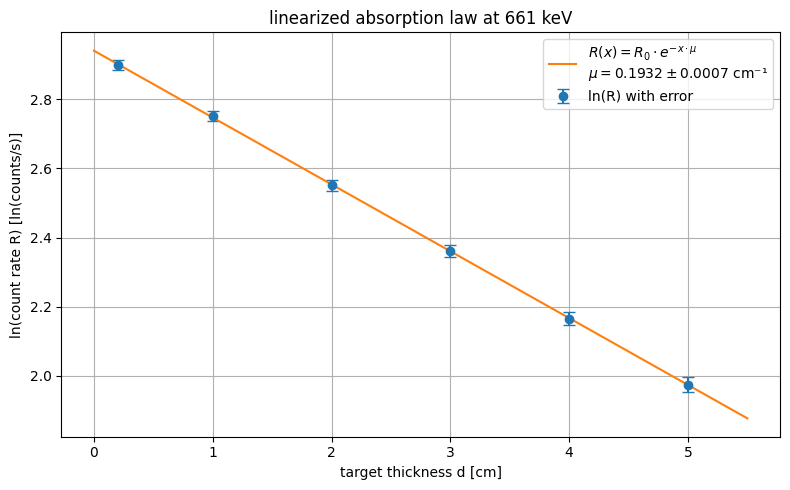

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Messdaten (aus Tabelle)
d = np.array([0.2, 1, 2, 3, 4, 5])  # cm
N = np.array([5300, 4672, 4056, 3213, 2636, 2176])  # Gesamtcounts
t = np.array([291.74, 298.42, 316.22, 302.84, 302.36, 301.96])  # Sekunden

# Zählrate und Fehler (Poisson-Statistik)
R = N / t  # Counts/s
R_err = np.sqrt(N) / t

# ln(R) und Fehler in ln(R)
ln_R = np.log(R)
ln_R_err = R_err / R  # Fehlerfortpflanzung: Δ(ln R) = ΔR / R

# Linearer Fit von ln(R) gegen d
slope, intercept, r_value, p_value, std_err = linregress(d, ln_R)
mu = -slope
mu_err = std_err
d_fit = np.linspace(0, 5.5, 300)
ln_R_fit = slope * d_fit + intercept

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(d, ln_R, yerr=ln_R_err, fmt='o', capsize=4, label='ln(R) with error')
plt.plot(d_fit, ln_R_fit, '-', label=fr'$R(x) = R_0 \cdot e^{{-x \cdot \mu}}$' + f'\n$\mu = {mu:.4f} \pm {mu_err:.4f}$ cm⁻¹')

plt.xlabel('target thickness d [cm]')
plt.ylabel('ln(count rate R) [ln(counts/s)]')
plt.title('linearized absorption law at 661 keV')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Compton Relation and the shift of the energies due to a wider incident angle

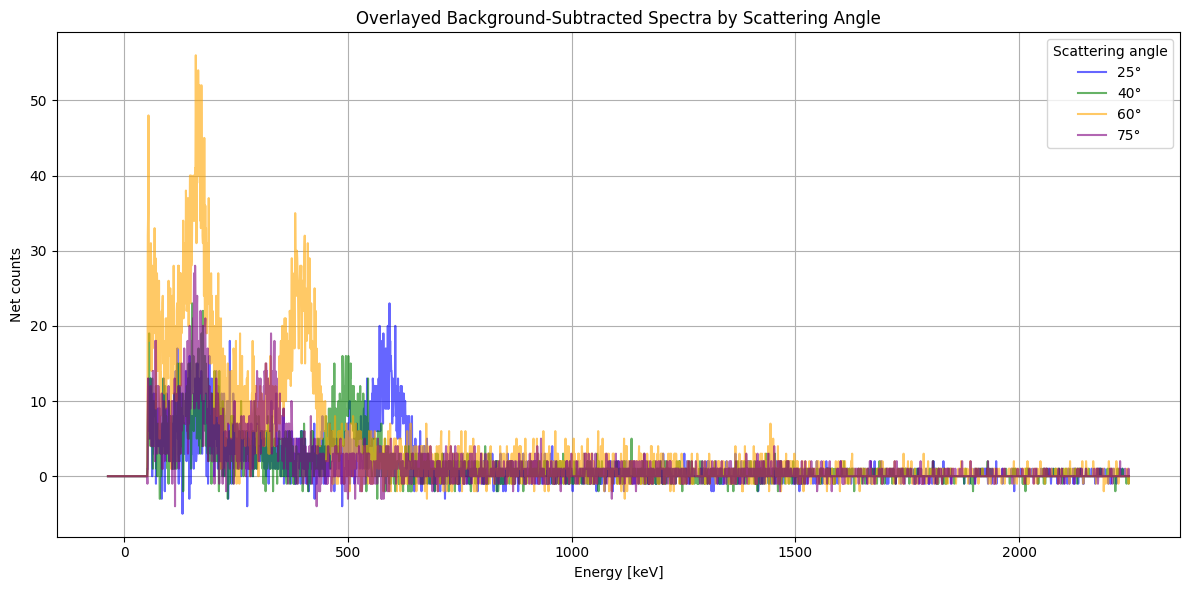


📁 Processing 25degreewithtarget.csv - 25degreewithouttarget.csv


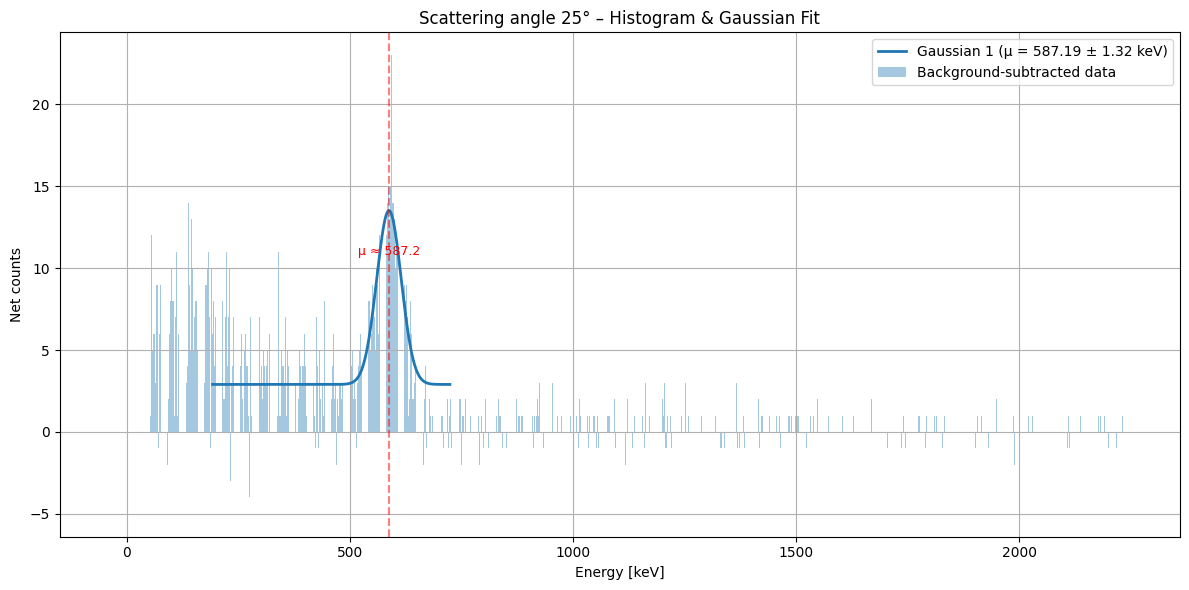

📍 Peak centers (μ ± Δμ in keV):
  Peak 1: μ = 587.19 ± 1.32 keV

📁 Processing 40degreewithtarget.csv - 40degreewithouttarget.csv


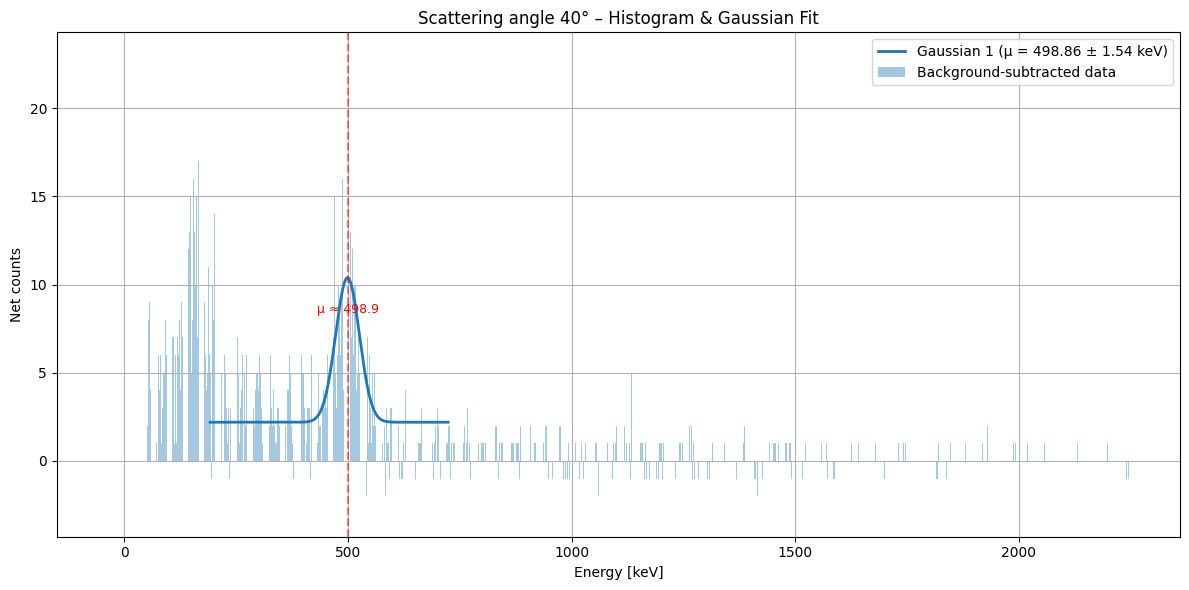

📍 Peak centers (μ ± Δμ in keV):
  Peak 1: μ = 498.86 ± 1.54 keV

📁 Processing 60degreewithtarget.csv - 60degreewithouttarget.csv


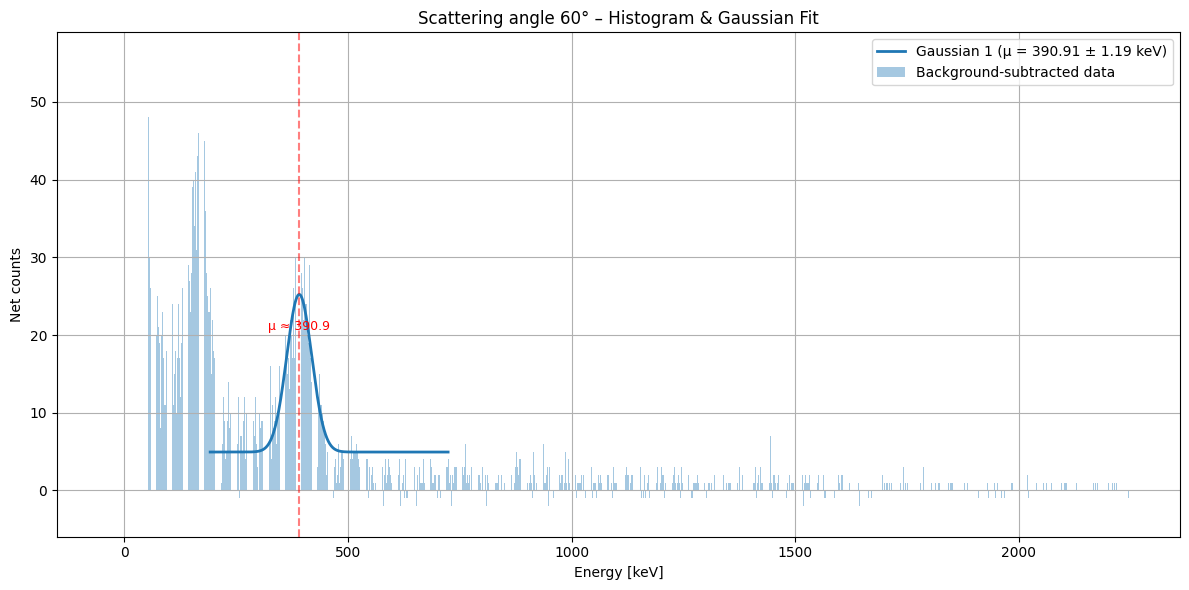

📍 Peak centers (μ ± Δμ in keV):
  Peak 1: μ = 390.91 ± 1.19 keV

📁 Processing 75degreewithtarget.csv - 75degreewithouttarget.csv


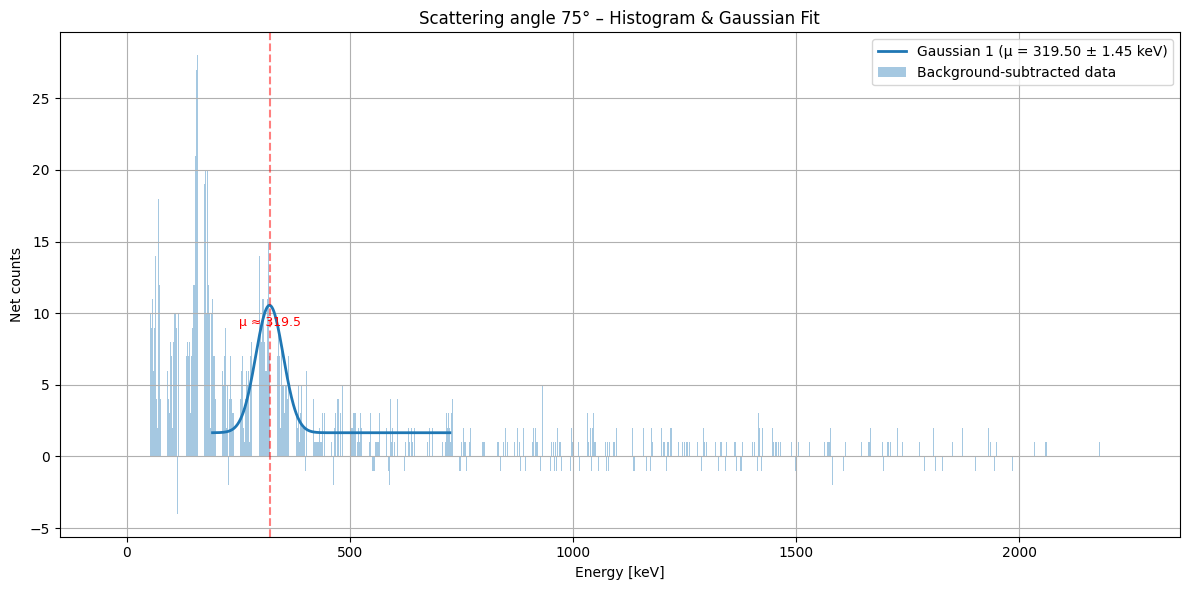

📍 Peak centers (μ ± Δμ in keV):
  Peak 1: μ = 319.50 ± 1.45 keV


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import re

# ======== CONFIGURATION ========
pairs = [
    ("25degreewithtarget.csv", "25degreewithouttarget.csv"),
    ("40degreewithtarget.csv", "40degreewithouttarget.csv"),
    ("60degreewithtarget.csv", "60degreewithouttarget.csv"),
    ("75degreewithtarget.csv", "75degreewithouttarget.csv")
]

peak_ranges = [
    (300, 1000)
]
max_entries = 3000
colors = ['blue', 'green', 'orange', 'purple']

# Calibration coefficients
a = 0.7610         # slope in keV/channel
b = -36.50         # offset in keV
# ================================

def gaussian(x, A, mu, sigma, offset):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) + offset

# === Overlay all subtracted histograms (line style) ===
plt.figure(figsize=(12, 6))

for idx, (fg_file, bg_file) in enumerate(pairs):
    df_fg = pd.read_csv(fg_file, header=None, dtype=str)
    df_fg[0] = df_fg[0].str.replace(";", "", regex=False)
    df_fg[0] = pd.to_numeric(df_fg[0], errors='coerce')
    fg_clean = df_fg[0].dropna().reset_index(drop=True).iloc[:max_entries]

    df_bg = pd.read_csv(bg_file, header=None, dtype=str)
    df_bg[0] = df_bg[0].str.replace(";", "", regex=False)
    df_bg[0] = pd.to_numeric(df_bg[0], errors='coerce')
    bg_clean = df_bg[0].dropna().reset_index(drop=True).iloc[:max_entries]

    min_len = min(len(fg_clean), len(bg_clean))
    y = fg_clean[:min_len].values - bg_clean[:min_len].values
    x_channel = np.arange(min_len)
    x_energy = a * x_channel + b

    angle_match = re.search(r"(\d+)", fg_file)
    angle = angle_match.group(1) if angle_match else f"Set {idx+1}"

    plt.plot(x_energy, y, label=f"{angle}°", color=colors[idx], alpha=0.6)

plt.title("Overlayed Background-Subtracted Spectra by Scattering Angle")
plt.xlabel("Energy [keV]")
plt.ylabel("Net counts")
plt.grid(True)
plt.legend(title="Scattering angle")
plt.tight_layout()
plt.show()

# === Individual Gaussian fits with histogram bars ===
for idx, (fg_file, bg_file) in enumerate(pairs):
    print(f"\n📁 Processing {fg_file} - {bg_file}")

    df_fg = pd.read_csv(fg_file, header=None, dtype=str)
    df_fg[0] = df_fg[0].str.replace(";", "", regex=False)
    df_fg[0] = pd.to_numeric(df_fg[0], errors='coerce')
    fg_clean = df_fg[0].dropna().reset_index(drop=True).iloc[:max_entries]

    df_bg = pd.read_csv(bg_file, header=None, dtype=str)
    df_bg[0] = df_bg[0].str.replace(";", "", regex=False)
    df_bg[0] = pd.to_numeric(df_bg[0], errors='coerce')
    bg_clean = df_bg[0].dropna().reset_index(drop=True).iloc[:max_entries]

    min_len = min(len(fg_clean), len(bg_clean))
    y = fg_clean[:min_len].values - bg_clean[:min_len].values
    x_channel = np.arange(min_len)
    x_energy = a * x_channel + b

    angle_match = re.search(r"(\d+)", fg_file)
    angle = angle_match.group(1) if angle_match else f"Set {idx+1}"

    plt.figure(figsize=(12, 6))
    plt.bar(x_energy, y, width=0.5, alpha=0.4, label="Background-subtracted data")

    peak_centers = []

    for i, (start, end) in enumerate(peak_ranges):
        x_peak = x_energy[start:end]
        y_peak = y[start:end]

        A0 = y_peak.max()
        mu0 = x_peak[np.argmax(y_peak)]
        sigma0 = 10
        offset0 = y_peak.min()
        p0 = [A0, mu0, sigma0, offset0]

        try:
            popt, pcov = curve_fit(gaussian, x_peak, y_peak, p0=p0)
            A, mu, sigma, offset = popt
            mu_err = np.sqrt(np.diag(pcov))[1]

            x_fit = np.linspace(x_peak[0], x_peak[-1], 500)
            y_fit = gaussian(x_fit, *popt)

            plt.plot(x_fit, y_fit, linewidth=2, label=f"Gaussian {i+1} (μ = {mu:.2f} ± {mu_err:.2f} keV)")
            plt.axvline(mu, color='red', linestyle='--', alpha=0.5)
            plt.text(mu, A, f"μ ≈ {mu:.1f}", ha="center", va="bottom", fontsize=9, color="red")
            peak_centers.append((mu, mu_err))

        except RuntimeError:
            print(f"⚠️ Fit {i+1} failed for {fg_file}")

    plt.title(f"Scattering angle {angle}° – Histogram & Gaussian Fit")
    plt.xlabel("Energy [keV]")
    plt.ylabel("Net counts")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("📍 Peak centers (μ ± Δμ in keV):")
    for i, (mu, mu_err) in enumerate(peak_centers, 1):
        print(f"  Peak {i}: μ = {mu:.2f} ± {mu_err:.2f} keV")


Theoretical energy values with found energys

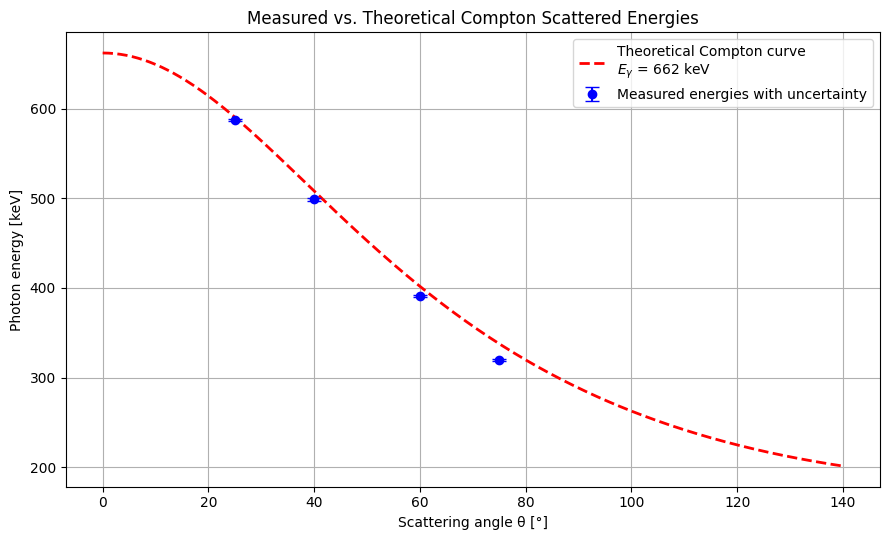

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Experimental data
angles_deg = np.array([25, 40, 60, 75])
energies_measured = np.array([587.19, 498.86, 390.91, 319.5])  # in keV
uncertainties = np.array([1.32, 1.54, 1.19, 1.45])  # in keV

# Constants
E_gamma = 662.0  # keV
m_e_c2 = 511.0   # keV

# Theoretical curve from 0° to 130° in small steps
theta_theo_deg = np.linspace(0, 140, 500)
theta_theo_rad = np.deg2rad(theta_theo_deg)
gamma = E_gamma / m_e_c2
E_theo = E_gamma / (1 + gamma * (1 - np.cos(theta_theo_rad)))

# Plotting
plt.figure(figsize=(9, 5.5))

# Theoretical smooth curve
plt.plot(theta_theo_deg, E_theo, 'r--', linewidth=2,
         label='Theoretical Compton curve\n$E_\\gamma$ = 662 keV')

# Measured data with uncertainties
plt.errorbar(angles_deg, energies_measured, yerr=uncertainties,
             fmt='o', color='blue', capsize=5, elinewidth=1.5,
             label='Measured energies with uncertainty')

# Labels and layout
plt.title('Measured vs. Theoretical Compton Scattered Energies')
plt.xlabel('Scattering angle θ [°]')
plt.ylabel('Photon energy [keV]')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


R_scattered for the Differential Cross section

  Angle  R_scattered [counts]  Uncertainty
0   25°           1315.979844   104.296522
1   40°            852.253613    94.190539
2   60°           2005.302620   123.570672
3   75°            751.988482    82.984162


Differential cross-section (theoretical vs measured)

In [67]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# ===== CONFIGURATION =====
files = {
    "25°": ("25degreewithtarget.csv", "25degreewithouttarget.csv"),
    "40°": ("40degreewithtarget.csv", "40degreewithouttarget.csv"),
    "60°": ("60degreewithtarget.csv", "60degreewithouttarget.csv"),
    "75°": ("75degreewithtarget.csv", "75degreewithouttarget.csv"),
}
max_entries = 3000
peak_range = (300, 1000)

# ===== GAUSSIAN FUNCTION =====
def gaussian(x, A, mu, sigma, offset):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) + offset

# ===== RESULT STORAGE =====
results = []

for angle, (fg_file, bg_file) in files.items():
    # Load and clean foreground
    df_fg = pd.read_csv(f"{fg_file}", header=None, dtype=str)
    df_fg[0] = df_fg[0].str.replace(";", "", regex=False)
    df_fg[0] = pd.to_numeric(df_fg[0], errors='coerce')
    fg_clean = df_fg[0].dropna().reset_index(drop=True).iloc[:max_entries]

    # Load and clean background
    df_bg = pd.read_csv(f"{bg_file}", header=None, dtype=str)
    df_bg[0] = df_bg[0].str.replace(";", "", regex=False)
    df_bg[0] = pd.to_numeric(df_bg[0], errors='coerce')
    bg_clean = df_bg[0].dropna().reset_index(drop=True).iloc[:max_entries]

    # Subtract background
    min_len = min(len(fg_clean), len(bg_clean))
    y = fg_clean[:min_len].values - bg_clean[:min_len].values
    x = np.arange(min_len)

    # Fit peak in defined range
    x_peak = x[peak_range[0]:peak_range[1]]
    y_peak = y[peak_range[0]:peak_range[1]]

    # Initial guess
    A0 = y_peak.max()
    mu0 = x_peak[np.argmax(y_peak)]
    sigma0 = 10
    offset0 = y_peak.min()
    p0 = [A0, mu0, sigma0, offset0]

    try:
        popt, pcov = curve_fit(gaussian, x_peak, y_peak, p0=p0)
        A, mu, sigma, offset = popt
        dA, dmu, dsigma, doffset = np.sqrt(np.diag(pcov))

        # Calculate R_scattered and uncertainty
        R = A * sigma * np.sqrt(2 * np.pi)
        dR = np.sqrt((sigma * np.sqrt(2 * np.pi) * dA) ** 2 +
                     (A * np.sqrt(2 * np.pi) * dsigma) ** 2)

        results.append({
            "Angle": angle,
            "A": A,
            "σ": sigma,
            "μ": mu,
            "R_scattered": R,
            "ΔA": dA,
            "Δσ": dsigma,
            "ΔR": dR
        })

    except RuntimeError:
        results.append({
            "Angle": angle,
            "A": np.nan,
            "σ": np.nan,
            "μ": np.nan,
            "R_scattered": np.nan,
            "ΔA": np.nan,
            "Δσ": np.nan,
            "ΔR": np.nan
        })

# Print results nicely
print("\n📊 Differential Cross Section Fit Results:")
for res in results:
    print(f"{res['Angle']}: A = {res['A']:.1f} ± {res['ΔA']:.1f}, "
          f"σ = {res['σ']:.1f} ± {res['Δσ']:.1f}, "
          f"μ = {res['μ']:.1f}, "
          f"R = {res['R_scattered']:.1f} ± {res['ΔR']:.1f}")



📊 Differential Cross Section Fit Results:
25°: A = 10.6 ± 0.5, σ = 36.1 ± 1.8, μ = 819.6, R = 961.6 ± 63.7
40°: A = 8.2 ± 0.4, σ = 34.9 ± 2.1, μ = 703.5, R = 716.3 ± 57.3
60°: A = 20.3 ± 0.8, σ = 36.9 ± 1.7, μ = 561.6, R = 1874.5 ± 110.2
75°: A = 8.9 ± 0.4, σ = 40.4 ± 2.0, μ = 467.8, R = 900.9 ± 59.1


Calculating R_gamma

In [69]:
import pandas as pd
import numpy as np

# Configuration
bg_files = [
    "25degreewithouttarget.csv",
    "40degreewithouttarget.csv",
    "60degreewithouttarget.csv",
    "75degreewithouttarget.csv"
]

max_entries = 3000
peak_range = (300, 1000)  # Adjust if needed for your peaks

def load_clean_data(filepath):
    df = pd.read_csv(filepath, header=None, dtype=str)
    df[0] = df[0].str.replace(";", "", regex=False)
    df[0] = pd.to_numeric(df[0], errors='coerce')
    return df[0].dropna().reset_index(drop=True).iloc[:max_entries]

# Loop over files
for file in bg_files:
    print(f"\n📁 Processing {file}")
    y = load_clean_data(file).values
    x = np.arange(len(y))

    # Get counts in peak range
    start, end = peak_range
    R_gamma = np.sum(y[start:end])
    dR_gamma = np.sqrt(R_gamma)  # Poisson uncertainty

    print(f"  R_gamma (sum in channel {start}–{end}): {R_gamma:.2f} ± {dR_gamma:.2f}")



📁 Processing 25degreewithouttarget.csv
  R_gamma (sum in channel 300–1000): 801.00 ± 28.30

📁 Processing 40degreewithouttarget.csv
  R_gamma (sum in channel 300–1000): 717.00 ± 26.78

📁 Processing 60degreewithouttarget.csv
  R_gamma (sum in channel 300–1000): 1328.00 ± 36.44

📁 Processing 75degreewithouttarget.csv
  R_gamma (sum in channel 300–1000): 651.00 ± 25.51


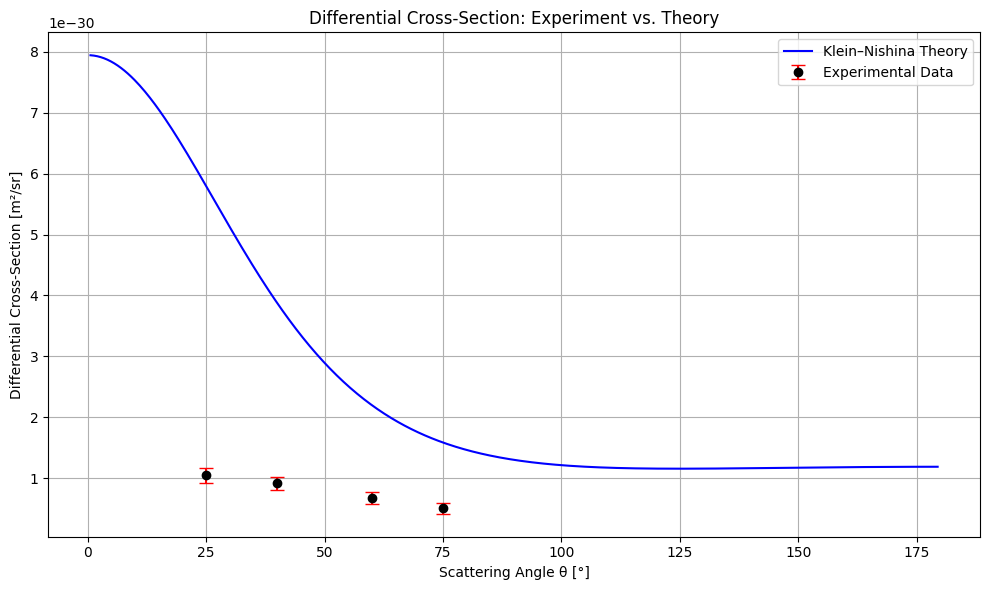

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# === Constants ===
E0 = 662  # keV, incident photon energy for Cs-137
m_e = 511  # keV, rest energy of electron
r_e = 2.818e-15  # classical electron radius in meters

# === Experimental Data ===
angles_deg = np.array([25, 40, 60, 75])
angles_rad = np.deg2rad(angles_deg)

# Experimental energies [keV] and uncertainties [keV]
E_exp = np.array([587.19, 498.86, 390.91, 319.5])
dE_exp = np.array([1.32, 1.54, 1.19, 1.45])

# Experimental differential cross-section values (in m²/sr)
dcs_exp = np.array([1.05e-30, 0.92e-30, 0.68e-30, 0.51e-30])      # example
dcs_exp_err = np.array([0.12e-30, 0.11e-30, 0.10e-30, 0.09e-30])  # example

# === Klein–Nishina formula ===
def klein_nishina(theta_rad):
    cos_theta = np.cos(theta_rad)
    sin_theta_sq = np.sin(theta_rad)**2
    E_prime = E0 / (1 + (E0 / m_e) * (1 - cos_theta))
    ratio = E_prime / E0
    return (r_e ** 2) / 2 * ratio ** 2 * (ratio + 1 / ratio - sin_theta_sq)

# === Generate smooth theoretical curve ===
theta_smooth = np.linspace(0.01, np.pi - 0.01, 500)
dcs_theory = klein_nishina(theta_smooth)

# === Plot ===
plt.figure(figsize=(10, 6))

# Theoretical curve
plt.plot(np.rad2deg(theta_smooth), dcs_theory, label='Klein–Nishina Theory', color='blue')

# Experimental data with error bars
plt.errorbar(angles_deg, dcs_exp, yerr=dcs_exp_err, fmt='o', color='black',
             ecolor='red', capsize=5, label='Experimental Data')

plt.xlabel("Scattering Angle θ [°]")
plt.ylabel("Differential Cross-Section [m²/sr]")
plt.title("Differential Cross-Section: Experiment vs. Theory")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
